In [178]:
import pandas as pd
import numpy as np
import sys, os
import seaborn as sns
from scipy.stats import hypergeom
from sklearn.metrics import normalized_mutual_info_score
from topicpy.hsbmpy import get_max_available_L, get_scores, add_score_lines
import matplotlib.pyplot as plt
import logging
log = logging.getLogger()

In [35]:
population=pd.read_csv("https://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None).values.ravel()

In [147]:
df_files = pd.read_csv("random11/files.dat", index_col=0)

In [10]:
genes = []
for directory in ["random11","random22","random33","random44","random55"]:
    genes.append(pd.read_csv(f"{directory}/mainTable.csv", index_col=0).index)

In [40]:
def get_pval(setA, setB):
    x = setA.isin(setB).sum() # number of successes
    M = len(population) # pop size
    k = len(setB) # successes in pop
    N = len(setA) # sample size
    pval = hypergeom.sf(x-1, M, k, N)
    return pval
#-np.log10(get_pval(setA, setB)+1)

In [76]:
overlaps = list(map(lambda setA: list(map(lambda setB: setA.isin(setB).sum()/float(len(setA)), genes)), genes))

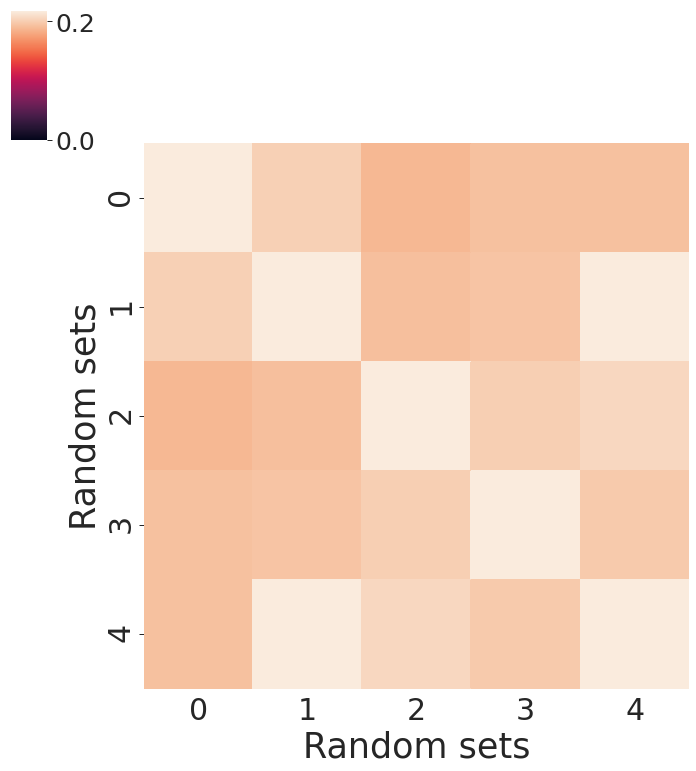

In [88]:
cm = sns.clustermap(overlaps, 
               row_cluster=False,
               col_cluster=False, 
               vmin=0,
                   vmax=max(list(map(lambda x: max(filter(lambda xi: xi<1,x)), overlaps)))
)

ax = cm.ax_heatmap
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Random sets", fontsize=35)
ax.set_xlabel("Random sets", fontsize=35)
ax.tick_params(labelsize=30)

bax = cm.ax_cbar
bax.tick_params(labelsize=25)

In [134]:
experiments = ["random11","random22","random33","random44","random55"]

In [141]:
scores = {}
for directory in experiments:
    scores[directory] = get_scores(directory, ["SMTS"], algorithm="tm")["SMTS"]

(1, 100)

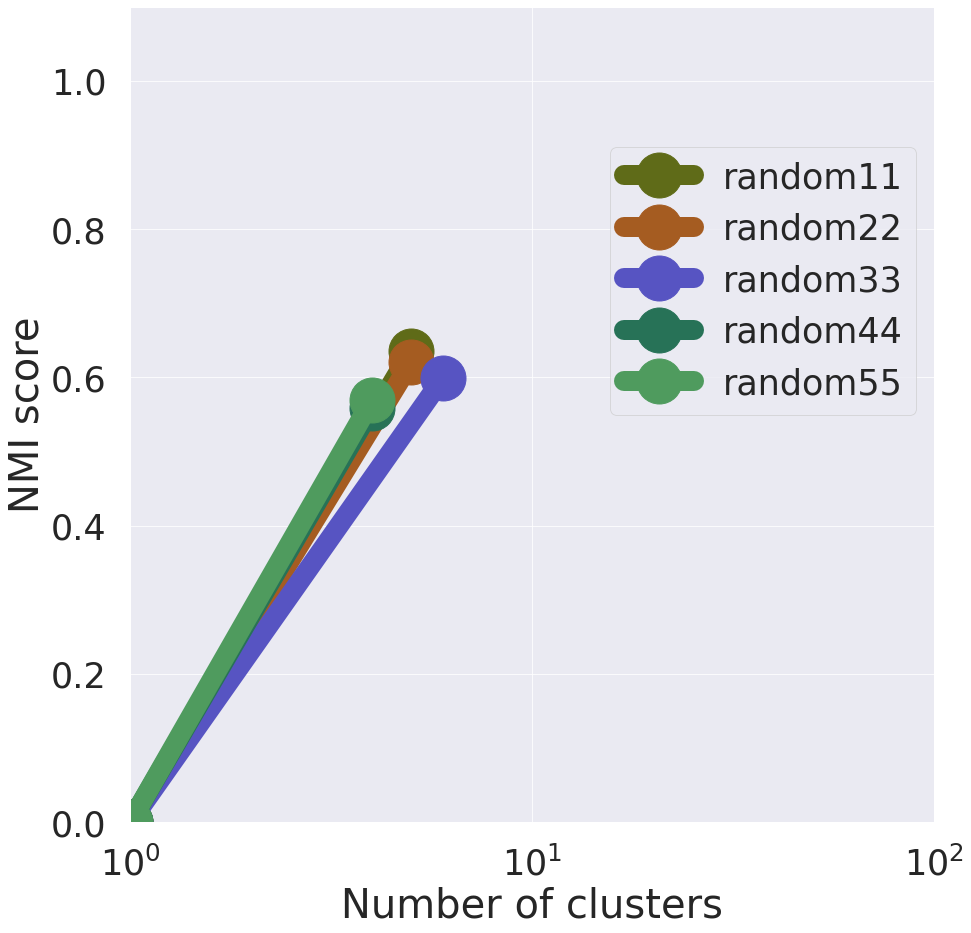

In [143]:
fig, ax = plt.subplots(figsize=(18,15))
add_score_lines(ax, scores, labels = experiments)
ax.set_xlim(1,100)

In [176]:
files = pd.DataFrame(index=df_files.reindex(index=pd.read_csv("random11/topsbm/topsbm_level_1_topic-dist.csv")["doc"]).index, columns = experiments)
for experiment in experiments:
    df_clusters = pd.read_csv(f"{experiment}/topsbm/topsbm_level_1_clusters.csv")
    for file in files.index:
        files.at[file, experiment]=df_clusters.columns[df_clusters[df_clusters==file].any(0)].values[0].split(" ")[1]

In [181]:
partitions = files.transpose().values

In [183]:
partition_overlap = list(map(lambda partitionA: list(map(lambda partitionB: normalized_mutual_info_score(partitionA, partitionB), partitions)), partitions))

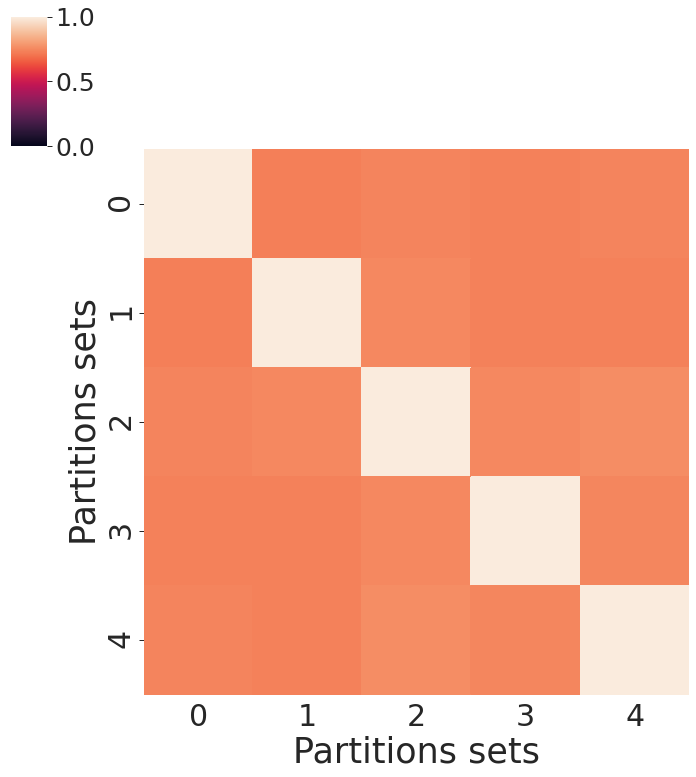

In [192]:
hm = sns.clustermap(partition_overlap, 
                    row_cluster=False,
                    col_cluster=False,
                 vmin=0)

ax = hm.ax_heatmap
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Partitions sets", fontsize=35)
ax.set_xlabel("Partitions sets", fontsize=35)
ax.tick_params(labelsize=30)

bax = hm.ax_cbar
bax.tick_params(labelsize=25)